In [1]:
import numpy as np
import pandas as pd
import os
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2022-05-12 14:58:52.645788: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-12 14:58:52.645938: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 1.5 MB/s eta 0:00:01


In [5]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("TPU_CONNECTED")
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.0.0.2:8470


2022-05-12 14:59:22.199642: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-12 14:59:22.199707: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}
2022-05-12 14:59:22.205465: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-12 14:59:22.205883: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}


TPU_CONNECTED
REPLICAS:  8


(1365, 2048, 3)


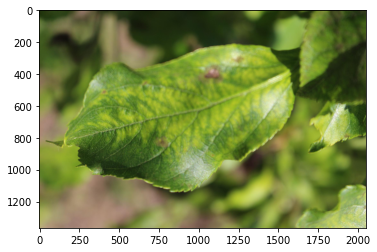

In [7]:
img = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
print(img.shape)
plt.imshow(img)

In [8]:
path='../input/plant-pathology-2020-fgvc7/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

train_paths = train.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values
test_paths = test.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values

train_labels = train.loc[:, 'healthy':].values

In [9]:
nb_classes = 4
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
img_size = 768
EPOCHS = 40
SEED = 123

In [10]:
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None, seed=2020):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
           
    if label is None:
        return image
    else:
        return image, label

In [11]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [12]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Learning rate schedule: 1e-05 to 0.0008 to 1.73e-05


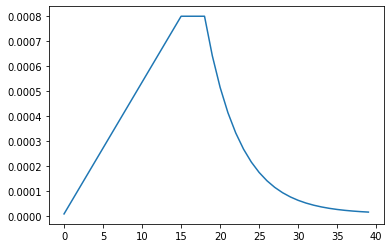

In [13]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [14]:
def get_model1():
    base_model =  efn.EfficientNetB7(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [15]:
def get_model2():
    base_model =  efn.EfficientNetB6(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [16]:
def get_model3():
    model = tf.keras.Sequential([
        ResNet152V2(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [17]:
def get_model4():
    model = tf.keras.Sequential([
        InceptionResNetV2(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [18]:
def get_model5():
    model = tf.keras.Sequential([
        InceptionV3(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [19]:
def get_model6():
    model = tf.keras.Sequential([
        Xception(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [20]:
def get_model7():
    model = tf.keras.Sequential([
        VGG19(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(train_labels.shape[1], activation='softmax')
    ])
    return model

In [21]:
with strategy.scope():
    model1 = get_model1()
    
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

258441216/258434480 [==============================] - 3s 0us/step


In [22]:
%%time
model1.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 260s 2s/step - loss: 1.3585 - categorical_accuracy: 0.3524
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
28/28 [==============================] - 36s 1s/step - loss: 1.1260 - categorical_accuracy: 0.6968
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
28/28 [==============================] - 36s 1s/step - loss: 0.4599 - categorical_accuracy: 0.8598
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 39s 1s/step - loss: 0.3624 - categorical_accuracy: 0.8774
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 37s 1s/step - loss: 0.2243 - categorical_accuracy: 0.9270
Epoch 6/40

Epoch 00006: LearningRateScheduler redu

In [23]:
with strategy.scope():
    model2 = get_model2()
    
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

165527552/165527152 [==============================] - 2s 0us/step


In [24]:
%%time
model2.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 208s 1s/step - loss: 1.3610 - categorical_accuracy: 0.3638
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
28/28 [==============================] - 40s 1s/step - loss: 1.1073 - categorical_accuracy: 0.6832
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
28/28 [==============================] - 40s 1s/step - loss: 0.4374 - categorical_accuracy: 0.8639
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 40s 1s/step - loss: 0.2676 - categorical_accuracy: 0.9222
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 39s 1s/step - loss: 0.2293 - categorical_accuracy: 0.9218
Epoch 6/40

Epoch 00006: LearningRateScheduler redu

In [25]:
with strategy.scope():
    model3 = get_model3()
    
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

234553344/234545216 [==============================] - 2s 0us/step


In [26]:
%%time
model3.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 178s 1s/step - loss: 1.2148 - categorical_accuracy: 0.4350
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
28/28 [==============================] - 39s 1s/step - loss: 0.6629 - categorical_accuracy: 0.8039
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
28/28 [==============================] - 40s 1s/step - loss: 0.3114 - categorical_accuracy: 0.9008
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 39s 1s/step - loss: 0.2067 - categorical_accuracy: 0.9369
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 39s 1s/step - loss: 0.2109 - categorical_accuracy: 0.9402
Epoch 6/40

Epoch 00006: LearningRateScheduler redu

In [27]:
with strategy.scope():
    model4 = get_model4()
    
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

219062272/219055592 [==============================] - 1s 0us/step


In [28]:
%%time
model4.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 205s 1s/step - loss: 1.3204 - categorical_accuracy: 0.2946
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
28/28 [==============================] - 39s 1s/step - loss: 0.7800 - categorical_accuracy: 0.7878
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
28/28 [==============================] - 39s 1s/step - loss: 0.3319 - categorical_accuracy: 0.8913
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 39s 1s/step - loss: 0.1988 - categorical_accuracy: 0.9388
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 38s 1s/step - loss: 0.1949 - categorical_accuracy: 0.9432
Epoch 6/40

Epoch 00006: LearningRateScheduler redu

In [29]:
with strategy.scope():
    model5 = get_model5()
    
model5.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [30]:
%%time
model5.fit(
   train_dataset, 
   steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
   callbacks=[lr_callback],
   epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 119s 1s/step - loss: 1.2816 - categorical_accuracy: 0.4031
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
28/28 [==============================] - 38s 1s/step - loss: 0.8232 - categorical_accuracy: 0.7338
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
28/28 [==============================] - 39s 1s/step - loss: 0.3830 - categorical_accuracy: 0.8722
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 38s 1s/step - loss: 0.2184 - categorical_accuracy: 0.9261
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 39s 1s/step - loss: 0.1671 - categorical_accuracy: 0.9492
Epoch 6/40

Epoch 00006: LearningRateScheduler redu

In [31]:
with strategy.scope():
    model6 = get_model6()
    
model6.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

83689472/83683744 [==============================] - 1s 0us/step


In [32]:
%%time
model6.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 39s 1s/step - loss: 0.4143 - categorical_accuracy: 0.8900
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 38s 1s/step - loss: 0.2124 - categorical_accuracy: 0.9308
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 39s 1s/step - loss: 0.1855 - categorical_accuracy: 0.9395
Epoch 6/40

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002733333333333334.
28/28 [==============================] - 38s 1s/step - loss: 0.1015 - categorical_accuracy: 0.9699
Epoch 7/40

Epoch 00007: LearningRateScheduler reducing learning rate to 0.000326.
28/28 [==============================] - 37s 1s/step - loss: 0.0845 - categorical_accuracy: 0.9746
Epoch 8/40

Epoch 00008: LearningRateScheduler reducing learning r

In [33]:
with strategy.scope():
    model7 = get_model7()
    
model7.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])

80142336/80134624 [==============================] - 1s 0us/step


In [34]:
%%time
model7.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
28/28 [==============================] - 65s 1s/step - loss: 1.3397 - categorical_accuracy: 0.2589
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 6.266666666666667e-05.
28/28 [==============================] - 38s 1s/step - loss: 1.1238 - categorical_accuracy: 0.4982
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00011533333333333334.
28/28 [==============================] - 36s 1s/step - loss: 1.4492 - categorical_accuracy: 0.3798
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000168.
28/28 [==============================] - 37s 1s/step - loss: 1.2306 - categorical_accuracy: 0.3782
Epoch 5/40

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00022066666666666667.
28/28 [==============================] - 37s 1s/step - loss: 1.2508 - categorical_accuracy: 0.3572
Epoch 6/40

Epoch 00006: LearningRateScheduler reduc

In [35]:
%%time
probs1 = model1.predict(test_dataset, verbose=1)
probs2 = model2.predict(test_dataset, verbose=1)
probs3 = model3.predict(test_dataset, verbose=1)
probs4 = model4.predict(test_dataset, verbose=1)
probs5 = model5.predict(test_dataset, verbose=1)
probs6 = model6.predict(test_dataset, verbose=1)
probs7 = model7.predict(test_dataset, verbose=1)
probs_avg = (2*probs1 + probs2 + probs3 + probs4 + probs5+ probs6 + probs7) / 8
sub.loc[:, 'healthy':] = probs_avg
sub.to_csv('s1.csv', index=False)
sub.head()

29/29 [==============================] - 52s 2s/step
CPU times: user 26.9 s, sys: 1.09 s, total: 28 s
Wall time: 7min 32s


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.035359,0.006397,0.917444,0.040800
1,Test_1,0.035379,0.006606,0.917208,0.040807
2,Test_2,0.035357,0.006265,0.042604,0.915774
3,Test_3,0.910200,0.006258,0.042680,0.040862
4,Test_4,0.035357,0.006577,0.917271,0.040795


In [42]:
np.argmax(probs_avg, axis=-1)

array([2, 2, 3, ..., 2, 0, 3])